In [1]:
import syft as sy

# Part 1: Join the Duet Server the Data Owner connected to

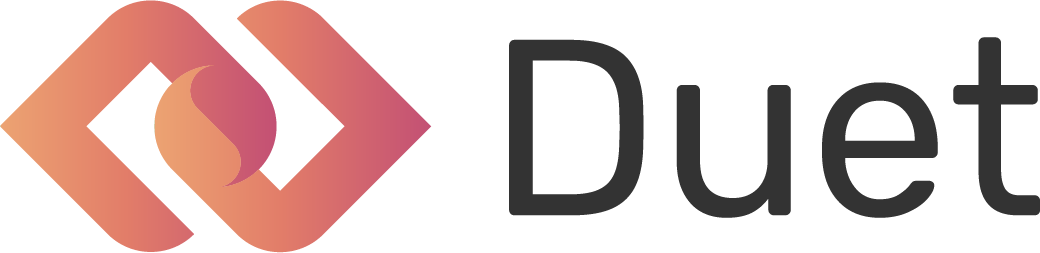

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-218-7-180.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!

♫♫♫ > CONNECTED!


In [2]:
duet = sy.join_duet(loopback=True)

### <img src="https://github.com/OpenMined/design-assets/raw/master/logos/OM/mark-primary-light.png" alt="he-black-box" width="100"/> Checkpoint 0 : Now STOP and run the Data Owner notebook until Checkpoint 1.

# Part 2: Search for Available Data


In [3]:
# The data scientist can check the list of pointable data in Data Owner's duet store
duet.store.pandas

,ID,Tags,Description,object_type
0,<UID: c501fae0383440c7913e15c44b6c24dc>,[iris-data],This is a dataset for flower classification of...,<class 'torch.Tensor'>
1,<UID: 373bd731b6ed42acbda78ac98702abc6>,[iris-target],"Labels for flowers: Iris-setosa, Iris-versicol...",<class 'torch.Tensor'>


In [4]:
# Data Scientist wants to get the iris dataset. (S)He needs a pointer to the data and
# a pointer to the target for prediction.
data_ptr = duet.store[0]
target_ptr = duet.store[1]

# data_ptr.requires_grad = True
# target_ptr.requires_grad = True

# data_ptr is a reference to the iris dataset remotely available on data owner's server
# target_ptr is a reference to the iris dataset LABELS
# remotely available on data owner's server
print(data_ptr)
print(target_ptr)

# Part 3: Perform Logistic Regression on Iris dataset

이제 데이터 과학자는 오너 데이터의 공유없이 듀엣 서버에 올려준 데이터를 사용해서 기계 학습을 수행할 수 있습니다.

### Basic analysis

First the data scientist needs to know some basic information about the dataset.
1. The length of the dataset
2. The input dimension
3. The output dimension

These information have to explicitly shared by the Data Owner. Let's try to find them in the data description.

In [ ]:
print(duet.store.pandas["Description"][0])

print(duet.store.pandas["Description"][1])

### Train model

In [6]:
import torch

In [7]:
in_dim = 4
out_dim = 3
n_samples = 150

In [26]:
class SyNet(sy.Module):
    def __init__(self, torch_ref):
        super(SyNet, self).__init__(torch_ref=torch_ref)
        
        self.layer1 = self.torch_ref.nn.Linear(in_dim, 20) #선형
        self.layer2 = self.torch_ref.nn.Linear(20, 30) # 선형
        self.out = self.torch_ref.nn.Linear(30, out_dim) #선형

    def forward(self, x):
        x = self.torch_ref.nn.functional.relu(self.layer1(x)) #relu
        x = self.torch_ref.nn.functional.relu(self.layer2(x))
        output = self.torch_ref.nn.functional.log_softmax(self.out(x), dim=1) #log softmax를 사용하여 3 개의 클래스로 분류
        return output


local_model = SyNet(torch)

In [27]:
remote_model = local_model.send(duet)

Let's create an alias for our partner’s torch called remote_torch so we can refer to the local torch as torch and any operation we want to do remotely as remote_torch. Remember, the return values from remote_torch are Pointers, not the real objects. They mostly act the same when using them with other Pointers but you can't mix them with local torch objects.

In [28]:
remote_torch = duet.torch

In [29]:
params = remote_model.parameters()
optim = remote_torch.optim.Adam(params=params, lr=0.01)

In [30]:
def train(iterations, model, torch_ref, optim, data_ptr, target_ptr):

    losses = []

    for i in range(iterations):

        optim.zero_grad()

        output = model(data_ptr) #X를 입력으로 사용
        #negative log-liklihood loss 사용 다중 클래스 분류에 사용되는 일반적인 함수
        loss = torch_ref.nn.functional.nll_loss(output, target_ptr.long()) 

        loss_item = loss.item()
        
        #loss item 값을 통해 모델이 제대로 훈련되는지 확인하기 위함
        #이렇게 하는 이유는 데이터 오너로부터 학습을 수행하기 때문
        loss_value = loss_item.get(
            reason="To evaluate training progress", request_block=True, timeout_secs=5
        )

        if i % 10 == 0:
            print("Epoch", i, "loss", loss_value)
        #위에서 구해진 값을 통해 loss에 추가함
        losses.append(loss_value)
        
        loss.backward()
        
        optim.step() #모델 파라미터를 업데이트하라는 명령

    return losses

In [31]:
iteration = 100
losses = train(iteration, remote_model, remote_torch, optim, data_ptr, target_ptr)

Epoch 0 loss 1.1721850633621216
Epoch 10 loss 0.49924495816230774
Epoch 20 loss 0.22165021300315857
Epoch 30 loss 0.09633097052574158
Epoch 40 loss 0.06918685138225555
Epoch 50 loss 0.060508474707603455
Epoch 60 loss 0.056678954511880875
Epoch 70 loss 0.05380704253911972
Epoch 80 loss 0.05228763073682785
Epoch 90 loss 0.050903286784887314


In [16]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'iteration')

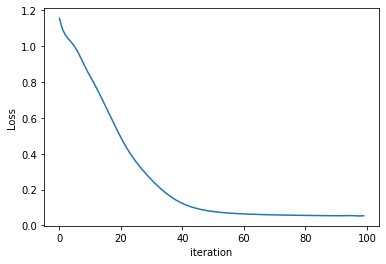

In [17]:
plt.plot(range(iteration), losses)
plt.ylabel("Loss")
plt.xlabel("iteration")

### Download model

In [32]:
def get_local_model(model):
    if not model.is_local:
        local_model = model.get(
            request_block=True,
            reason="To run test and inference locally",
            timeout_secs=5,
        )
    else:
        local_model = model

    return local_model


local_model = get_local_model(remote_model)

### Test on local data

In [33]:
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

In [34]:
url = "https://raw.githubusercontent.com/znreza/Federated-Learning-Course-Material/main/Lecture%20Notebooks/Duet%20Iris%20Classifier/"

iris_test = pd.read_csv(f"{url}data/iris-test.csv")
iris_test.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.8,4.0,1.2,0.2,0
1,5.7,4.4,1.5,0.4,0
2,6.0,2.7,5.1,1.6,1
3,6.0,2.9,4.5,1.5,1
4,5.8,2.7,5.1,1.9,2


In [35]:
X_test = iris_test.loc[:, iris_test.columns != "species"]
y_test = iris_test["species"]

In [36]:
X_test = torch.FloatTensor(np.array(X_test))
y_test = torch.LongTensor(np.array(y_test))

In [37]:
preds = []
with torch.no_grad():
    for i in range(len(X_test)):
        sample = X_test[i]
        y_hat = local_model(sample.unsqueeze(0))
        pred = y_hat.argmax().item()
        print(f"Prediction: {pred} Ground Truth: {y_test[i]}")
        preds.append(pred)

Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 2 Ground Truth: 1
Prediction: 1 Ground Truth: 1
Prediction: 2 Ground Truth: 2
Prediction: 0 Ground Truth: 0
Prediction: 1 Ground Truth: 1
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 2 Ground Truth: 2
Prediction: 2 Ground Truth: 2
Prediction: 2 Ground Truth: 2
Prediction: 2 Ground Truth: 2
Prediction: 2 Ground Truth: 2
Prediction: 2 Ground Truth: 2
Prediction: 1 Ground Truth: 1
Prediction: 0 Ground Truth: 0
Prediction: 2 Ground Truth: 1
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 2 Ground Truth: 2
Prediction: 2 Ground Truth: 2
Prediction: 0 Ground Truth: 0
Prediction: 2 Ground Truth: 2
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 2 Ground Truth: 2
Prediction: 2 Ground Truth: 2


In [38]:
acc = accuracy_score(y_test, preds)
print("Overall test accuracy", acc * 100)

Overall test accuracy 93.33333333333333
